
# AstroInfo — Spectral Classification with Transformers (Auto + Downloader)

**Last updated:** 2025-10-28 18:04 UTC  
Run top-to-bottom. Requires internet for astroquery cells.


# 📘 Introduction: Applying Transformers to 1D Galaxy Spectra

In optical astronomy, spectra encode the physical properties of galaxies: stellar populations, kinematics, chemical composition, and current star formation. These properties are strongly correlated with **galaxy morphology** (e.g., Elliptical vs. Spiral). Instead of classifying morphology from images alone, we can infer it directly from the **physics inside the spectrum**.

Spectra are **1D sequences** — flux intensities binned across wavelength — and Transformers, originally designed for language modeling, excel at modeling **long-range dependencies** in sequential data. This makes Transformers a powerful tool for spectral analysis.



## Why Transformers for Galaxy Spectra?

Spectra are rich in **diagnostic features** that are not always local:

| Spectral Property                | Importance                                     |
| -------------------------------- | ---------------------------------------------- |
| Absorption & emission lines      | Indicate stellar age, metallicity, ionization  |
| Continuum slope                  | Traces dust and stellar population mix         |
| Features far apart in wavelength | Can be physically linked (e.g., Balmer series) |

Transformers capture **global** relationships through **self-attention**, where any wavelength can attend to any other ― ideal for spectral physics.


## Architecture: 1D Spectral Transformer

The model adapts the Vision Transformer (ViT) architecture into **one dimension**:

1. Resample spectrum → fixed length sequence (1024)
2. Patch embedding: 1D convolution splits sequence into patches
3. Add special **CLS token** for classification
4. Inject **wavelength positional encoding**
5. Transformer encoder layers extract global spectral patterns
6. Classification head predicts morphology class

### ✔ Architecture Diagram

*(Generated earlier — included inline here)*

📌 **Spectral Transformer Block Diagram**
![Spectral Transformer Architecture](sandbox:spectral_transformer_diagram.png)

➡ Input: 1D flux array
➡ Output: Galaxy morphology label


## Difference vs. 2D Image Transformers (ViT)

| Feature          | 2D ViT (images)           | 1D Spectral Transformer            |
| ---------------- | ------------------------- | ---------------------------------- |
| Data shape       | Height × Width × Channels | Flux × Wavelength                  |
| Patch type       | 2D grid segments          | 1D contiguous segments             |
| Physical meaning | Spatial structures        | Astrophysical spectral diagnostics |
| Augmentation     | flips, crops              | noise, wavelength jitter           |
| Dependencies     | local + global            | mostly global                      |

**Key point:**
Images contain **visual** information.
Spectra contain **physical** information.

Transformers can exploit the latter to infer morphology from stellar content and gas properties ― not just galaxy shape.


## How Training Works

Given examples of:

* Spectrum → its morphology bin (E / S0 / SaSb / ScSd) : each spectrum is labeled with the galaxy morphology bin it belongs to.
| Morphology bin | Meaning             |
| -------------- | ------------------- |
| **E**          | Elliptical galaxies |
| **S0**         | Lenticular galaxies |
| **SaSb**       | Early-type spirals  |
| **ScSd**       | Late-type spirals   |

We want the model to learn:
    From a galaxy’s spectrum → predict its morphology bin


The model learns a mapping using:

* Supervised classification
* Cross-entropy loss
* Modern optimization: AdamW + cosine learn rate schedule
* Robust train/val/test splitting to avoid class imbalance issues

The **CLS token** representation gradually becomes the model’s learned embedding of galaxy physical properties.




In [28]:

# --- Create directories if not exist ---
import os
os.makedirs('spectra', exist_ok=True)
os.makedirs('images', exist_ok=True)
os.makedirs('catalog', exist_ok=True)
os.makedirs('intermediate', exist_ok=True)
print("Folders ready.")


Folders ready.


In [29]:

# --- Download Nair & Abraham (2010) from VizieR ---
# !pip install astroquery
from astroquery.vizier import Vizier
import pandas as pd, os
Vizier.ROW_LIMIT = -1
catalog_id = 'J/ApJS/186/427'
vizier = Vizier(columns=['*'])
result = vizier.get_catalogs(catalog_id)
catalog_df = result[0].to_pandas()
os.makedirs('./catalog', exist_ok=True)
catalog_df.to_csv('./catalog/nair_abraham_2010.csv', index=False)
print(f"Downloaded {len(catalog_df)} rows to ./catalog/nair_abraham_2010.csv")
print(list(catalog_df.columns)[:20])
catalog_df.head()


Downloaded 50 rows to ./catalog/nair_abraham_2010.csv
['SDSS', 'zs', "g'mag", "r'mag", 'log(M)', 'Age', 'b/a', 'sigma', 'TT', '_RA', '_DE']


,SDSS,zs,g'mag,r'mag,log(M),Age,b/a,sigma,TT,_RA,_DE
0,J155341.74-003422.84,0.078,15.820,15.058,11.083,4.459,0.794,143.679993,3,238.42392,-0.573011
1,J155146.83-000618.62,0.055,15.512,14.606,11.245,7.111,0.954,204.809998,-5,237.94512,-0.105172
2,J154453.22+002415.48,0.034,15.631,14.838,10.405,4.287,0.848,129.970001,-2,236.22175,0.404300
3,J154711.32+002424.81,0.033,15.716,15.158,10.156,1.901,0.854,45.250000,4,236.79717,0.406892
4,J154514.39+004619.89,0.013,15.341,14.956,9.173,1.891,0.329,89.320000,5,236.30996,0.772192


1) Full-catalog robust SDSS matching (hours→deg, 5″ radius, SQL by objID if available)

In [30]:
# --- FULL CATALOG → SDSS spectra matching (resume-safe) ---
import os, time, numpy as np, pandas as pd
from astropy import units as u
from astropy import coordinates as coords
from astroquery.sdss import SDSS

CATALOG_CSV = "./catalog/nair_abraham_2010.csv"
INTER_DIR   = "./intermediate"
SPEC_DIR    = "./spectra"
os.makedirs(INTER_DIR, exist_ok=True)
os.makedirs(SPEC_DIR, exist_ok=True)
MATCHES_CSV = os.path.join(INTER_DIR, "sdss_spectra_matches.csv")

# Load catalog
assert os.path.exists(CATALOG_CSV), "Missing catalog file at ./catalog/nair_abraham_2010.csv"
cat = pd.read_csv(CATALOG_CSV)
print("Catalog rows:", len(cat))

# Column selection helpers
def find_col(df, options):
    for k in options:
        if k in df.columns:
            return k
    return None

RA_COL  = find_col(cat, ["_RA","ra","RA","alpha","ra_deg","ra2000","RA2000","RAJ2000"])
DE_COL  = find_col(cat, ["_DE","dec","DEC","delta","de_deg","dec2000","DEC2000","DEJ2000"])
OBJ_COL = find_col(cat, ["bestObjID","BESTOBJID","objID","ObjID"])
NAMECOL = find_col(cat, ["SDSS","sdss_name","J2000","ID","name"])

assert RA_COL and DE_COL, f"Could not find RA/Dec columns. Found columns: {list(cat.columns)[:20]}"

# Detect RA units (hours → degrees)
ra_vals = pd.to_numeric(cat[RA_COL], errors="coerce")
is_hours = ra_vals.dropna().max() <= 24.5
print(f"Using RA='{RA_COL}' (hours={is_hours}), Dec='{DE_COL}'")

def to_skycoord(ra, dec):
    ra = float(ra)
    dec = float(dec)
    if is_hours:
        ra *= 15.0
    return coords.SkyCoord(ra*u.deg, dec*u.deg)

SEARCH_RADIUS = 5.0 * u.arcsec  # can bump to 7.0″ if needed
PAUSE_SEC = 0.20

# Resume support
matches = []
done_ids = set()
if os.path.exists(MATCHES_CSV):
    old = pd.read_csv(MATCHES_CSV)
    matches = old.to_dict(orient="records")
    done_ids = set(old["source_id"].astype(str))
    print(f"Resuming from {len(old)} existing matches at {MATCHES_CSV}")

# Ensure source_id in catalog
if "source_id" not in cat.columns:
    cat["source_id"] = [f"nair_{i}" for i in range(len(cat))]

def save_matches_now():
    pd.DataFrame(matches).to_csv(MATCHES_CSV, index=False)

def best_row_by_sep(tbl, target):
    if tbl is None or len(tbl) == 0:
        return None, None
    ra_key  = "ra"  if "ra"  in tbl.colnames else ("RA"  if "RA"  in tbl.colnames else None)
    dec_key = "dec" if "dec" in tbl.colnames else ("DEC" if "DEC" in tbl.colnames else None)
    if ra_key and dec_key:
        seps = []
        for r in tbl:
            sc = coords.SkyCoord(float(r[ra_key])*u.deg, float(r[dec_key])*u.deg)
            seps.append(target.separation(sc).arcsec)
        i = int(np.argmin(seps))
        return tbl[i], float(seps[i])
    return tbl[0], None

def sql_by_objid(objid):
    q = f"""
    SELECT s.plate, s.mjd, s.fiberID, s.specobjid, s.ra, s.dec
    FROM SpecObjAll AS s
    WHERE s.bestObjID = {int(objid)}
    """
    try:
        return SDSS.query_sql(q)
    except Exception:
        return None

found = skipped = failed = 0

# Iterate over rows with valid coords (Series → label access)
for idx, row in cat.dropna(subset=[RA_COL, DE_COL]).iterrows():
    sid = str(row["source_id"])
    if sid in done_ids:
        skipped += 1
        continue

    sdss_name = str(row[NAMECOL]) if (NAMECOL and pd.notna(row.get(NAMECOL))) else sid

    # Build target coord
    try:
        sc = to_skycoord(row[RA_COL], row[DE_COL])
    except Exception as e:
        print(f"Bad coords at {sid}: {e}")
        failed += 1
        continue

    # Prefer SQL by bestObjID/objID
    spec_tbl = None
    if OBJ_COL and pd.notna(row.get(OBJ_COL)):
        spec_tbl = sql_by_objid(row[OBJ_COL])

    # Otherwise cone search
    if spec_tbl is None or len(spec_tbl) == 0:
        try:
            spec_tbl = SDSS.query_region(sc, radius=SEARCH_RADIUS, spectro=True)
        except Exception as e:
            print(f"query_region fail at {sid}: {e}")
            spec_tbl = None
        time.sleep(PAUSE_SEC)

    if spec_tbl is None or len(spec_tbl) == 0:
        failed += 1
        if failed % 200 == 0:
            print(f"...progress: found={found}, failed={failed}, skipped={skipped}")
        continue

    best, sep = best_row_by_sep(spec_tbl, sc)

    # Robust field access (case-insensitive)
    try:
        plate     = int(best["plate"])
        fiberID   = int(best["fiberID"])
        mjd       = int(best["mjd"])
        specobjid = int(best["specobjid"])
    except Exception:
        keys = {k.lower(): k for k in best.keys()}
        plate     = int(best[keys["plate"]])
        fiberID   = int(best[keys["fiberid"]])
        mjd       = int(best[keys["mjd"]])
        specobjid = int(best[keys["specobjid"]])

    fits_path = os.path.join(SPEC_DIR, f"spec-{specobjid}.fits")
    if not os.path.exists(fits_path):
        try:
            sp = SDSS.get_spectra(plate=plate, fiberID=fiberID, mjd=mjd)
            if sp:
                sp[0].writeto(fits_path, overwrite=True)
            else:
                failed += 1
                continue
        except Exception as e:
            print(f"get_spectra fail at {sid}: {e}")
            failed += 1
            continue

    matches.append({
        "source_id": sid,
        "sdss_name": sdss_name,
        "ra": float(row[RA_COL]) * (15.0 if is_hours else 1.0),
        "dec": float(row[DE_COL]),
        "specobjid": specobjid,
        "spectrum_file": fits_path,
        "plate": plate,
        "fiber": fiberID,
        "mjd": mjd,
        "sep_arcsec": sep
    })
    found += 1

    if found % 250 == 0:
        save_matches_now()
        print(f"...progress: found={found}, failed={failed}, skipped={skipped}")

# Final save
save_matches_now()
print(f"Done. Matches: {found} | failed={failed} | skipped={skipped}")


Catalog rows: 50
Using RA='_RA' (hours=False), Dec='_DE'
Resuming from 49 existing matches at ./intermediate/sdss_spectra_matches.csv


Done. Matches: 0 | failed=1 | skipped=49


2) Build master_dataset_binned.csv (Option A bins) from all matches

In [31]:
# --- Build master + bin TT into E / S0 / SaSb / ScSd ---
import pandas as pd, os

CATALOG_CSV = "./catalog/nair_abraham_2010.csv"
MATCHES_CSV = "./intermediate/sdss_spectra_matches.csv"
assert os.path.exists(MATCHES_CSV), "Run the matching cell first."

spec_df = pd.read_csv(MATCHES_CSV)
cat = pd.read_csv(CATALOG_CSV)

if "source_id" not in cat.columns:
    cat["source_id"] = [f"nair_{i}" for i in range(len(cat))]

master = spec_df.merge(cat, on="source_id", how="left")
assert "TT" in master.columns, "No 'TT' column found in catalog."

def tt_bin(tt):
    tt = float(tt)
    if tt <= -3:       return "E"
    elif -3 < tt <= 0: return "S0"
    elif 1 <= tt <= 3: return "SaSb"
    elif tt >= 4:      return "ScSd"
    else:              return "Unknown"

df = master.dropna(subset=["TT","spectrum_file"]).copy()
df["TT_BIN"] = df["TT"].astype(float).apply(tt_bin)
df = df[df["TT_BIN"] != "Unknown"].copy()
print("Bin counts:\n", df["TT_BIN"].value_counts())

out = df[["source_id","sdss_name","spectrum_file","TT_BIN"]].rename(columns={"TT_BIN":"label"})
out.to_csv("./master_dataset_binned.csv", index=False)
print("Wrote ./master_dataset_binned.csv with", len(out), "rows")


Bin counts:
 TT_BIN
SaSb    19
E       11
S0       8
ScSd     8
Name: count, dtype: int64
Wrote ./master_dataset_binned.csv with 46 rows


3) Auto-config, encode labels, clean

In [32]:
# --- Auto-config for binned dataset ---
import os, pandas as pd
from sklearn.preprocessing import LabelEncoder

DATA_CSV = "./master_dataset_binned.csv"
df = pd.read_csv(DATA_CSV)

FILE_COLUMN  = "spectrum_file"
LABEL_COLUMN = "label"

# Fix paths
base_dirs = [".","./spectra","/mnt/data","./data","./fits"]
def fix_path(p):
    p = str(p).strip()
    if os.path.isabs(p) and os.path.exists(p): return p
    if os.path.exists(p): return p
    for b in base_dirs:
        cand = os.path.normpath(os.path.join(b, p))
        if os.path.exists(cand): return cand
    return p
df[FILE_COLUMN] = df[FILE_COLUMN].astype(str).apply(fix_path)

# Drop missing label/file
before = len(df)
df = df.dropna(subset=[LABEL_COLUMN, FILE_COLUMN]).copy()
print(f"Dropped {before - len(df)} rows lacking label/file.")

# Encode labels
le = LabelEncoder()
df[LABEL_COLUMN] = le.fit_transform(df[LABEL_COLUMN].astype(str))
CLASS_NAMES = list(le.classes_)
NUM_CLASSES = df[LABEL_COLUMN].nunique()
print("Classes:", CLASS_NAMES, "| NUM_CLASSES:", NUM_CLASSES)

CLEAN_CSV = "./master_dataset_binned_clean.csv"
df.to_csv(CLEAN_CSV, index=False)

# Export config
DATA_CSV = CLEAN_CSV
TARGET_LEN = 1024
print("Prepared:", DATA_CSV)


Dropped 0 rows lacking label/file.
Classes: ['E', 'S0', 'SaSb', 'ScSd'] | NUM_CLASSES: 4
Prepared: ./master_dataset_binned_clean.csv


4) Dataset class (defined if missing), robust split, and DataLoaders

In [33]:
# --- FITS → tensor dataset + robust split/loaders ---
import os, numpy as np, pandas as pd, torch
from torch.utils.data import Dataset
from astropy.io import fits
from sklearn.model_selection import train_test_split

FILE_COLUMN  = "spectrum_file"
LABEL_COLUMN = "label"

def _read_flux_from_fits(path):
    with fits.open(path, memmap=False) as hdul:
        for hdu in hdul:
            if getattr(hdu, "data", None) is None:
                continue
            if hasattr(hdu, "columns"):
                for key in ("flux","FLUX"):
                    if key in getattr(hdu, "columns", []):
                        arr = np.asarray(hdu.data[key]).astype(np.float32)
                        return arr.squeeze()
            if isinstance(hdu.data, np.ndarray) and hdu.data.ndim == 1:
                return hdu.data.astype(np.float32)
            if isinstance(hdu.data, np.ndarray) and hdu.data.ndim > 1:
                return hdu.data[0].astype(np.float32).squeeze()
    return np.zeros(32, dtype=np.float32)

def _resample_1d(x, target_len):
    x = np.nan_to_num(x, nan=0.0, posinf=0.0, neginf=0.0).astype(np.float32)
    n = len(x)
    if n == target_len: return x
    if n <= 1: return np.zeros(target_len, dtype=np.float32)
    xi = np.linspace(0, n-1, n)
    xo = np.linspace(0, n-1, target_len)
    return np.interp(xo, xi, x).astype(np.float32)

class SpectraFilesDataset(Dataset):
    def __init__(self, df, file_col, label_col, target_len=1024, log_scale=False, normalize=False):
        self.df = df.reset_index(drop=True)
        self.file_col = file_col
        self.label_col = label_col
        self.target_len = int(target_len)
        self.log_scale = log_scale
        self.normalize = normalize
    def __len__(self): return len(self.df)
    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        path = str(row[self.file_col])
        y = int(row[self.label_col])
        try:
            flux = _read_flux_from_fits(path) if os.path.exists(path) else np.zeros(self.target_len, np.float32)
        except Exception:
            flux = np.zeros(self.target_len, np.float32)
        if self.log_scale:
            flux = np.sign(flux) * np.log1p(np.abs(flux))
        if self.normalize:
            m, s = np.mean(flux), np.std(flux) + 1e-8
            flux = (flux - m) / s
        x = _resample_1d(flux, self.target_len)
        return torch.from_numpy(x.astype(np.float32)), torch.tensor(y, dtype=torch.long)

# Load cleaned data
df_all = pd.read_csv(DATA_CSV)

# Robust split: pin classes with <2 samples to TRAIN
y = df_all[LABEL_COLUMN]
counts = y.value_counts()
rare_classes = counts[counts < 2].index.tolist()
print(f"[Split] Total={len(df_all)} | classes={counts.shape[0]} | min per-class={counts.min()}")

if len(rare_classes) > 0:
    print(f"[Split] Pinning rare classes to TRAIN only: {sorted(rare_classes)}")
    rare_df = df_all[df_all[LABEL_COLUMN].isin(rare_classes)]
    rest_df = df_all[~df_all[LABEL_COLUMN].isin(rare_classes)]
else:
    rare_df = df_all.iloc[0:0]
    rest_df = df_all

def safe_two_stage_split(df, first_test_frac=0.30, seed=42, stratify_series=None):
    n = len(df)
    if n == 0:
        return df.iloc[0:0], df.iloc[0:0], df.iloc[0:0]
    if n >= 2:
        n_test1 = max(1, int(round(first_test_frac * n)))
        if n_test1 >= n: n_test1 = n - 1
        if stratify_series is not None:
            tr, tmp = train_test_split(df, test_size=n_test1, random_state=seed, stratify=stratify_series)
        else:
            tr, tmp = train_test_split(df, test_size=n_test1, random_state=seed, shuffle=True)
    else:
        tr, tmp = df, df.iloc[0:0]
    m = len(tmp)
    if m >= 2:
        n_test2 = max(1, m//2)
        va, te = train_test_split(tmp, test_size=n_test2, random_state=seed, shuffle=True)
    elif m == 1:
        va, te = tmp, tmp.iloc[0:0]
    else:
        va, te = tmp, tmp
    return tr, va, te

can_stratify = (len(rest_df) >= 4) and (rest_df[LABEL_COLUMN].value_counts().min() >= 2)
if len(rest_df) == 0:
    print("[Split] All samples rare → all to TRAIN; VAL/TEST empty.")
    train_df, val_df, test_df = df_all.copy(), df_all.iloc[0:0].copy(), df_all.iloc[0:0].copy()
else:
    if can_stratify:
        train2, val2, test2 = safe_two_stage_split(rest_df, first_test_frac=0.30, seed=42, stratify_series=rest_df[LABEL_COLUMN])
    else:
        print("[Split] Non-stratified split (insufficient per-class counts).")
        train2, val2, test2 = safe_two_stage_split(rest_df, first_test_frac=0.30, seed=42, stratify_series=None)
    train_df = pd.concat([rare_df, train2], ignore_index=True)
    val_df   = val2.reset_index(drop=True)
    test_df  = test2.reset_index(drop=True)

print(f"[Split] Train={len(train_df)}, Val={len(val_df)}, Test={len(test_df)}")

# DataLoaders
BATCH_SIZE = 64
NUM_WORKERS = 2
train_ds = SpectraFilesDataset(train_df, FILE_COLUMN, LABEL_COLUMN, target_len=1024)
val_ds   = SpectraFilesDataset(val_df,   FILE_COLUMN, LABEL_COLUMN, target_len=1024)
test_ds  = SpectraFilesDataset(test_df,  FILE_COLUMN, LABEL_COLUMN, target_len=1024)

train_loader = torch.utils.data.DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True,  num_workers=NUM_WORKERS, pin_memory=True)
val_loader   = torch.utils.data.DataLoader(val_ds,   batch_size=BATCH_SIZE, shuffle=False, num_workers=NUM_WORKERS, pin_memory=True)
test_loader  = None
if len(test_ds) > 0:
    test_loader = torch.utils.data.DataLoader(test_ds, batch_size=BATCH_SIZE, shuffle=False, num_workers=NUM_WORKERS, pin_memory=True)

if len(train_ds) > 0:
    xb, yb = next(iter(train_loader))
    print("Batch shapes:", xb.shape, yb.shape)


[Split] Total=46 | classes=4 | min per-class=8
[Split] Train=32, Val=7, Test=7


Batch shapes: torch.Size([32, 1024]) torch.Size([32])


5) Train your Transformer (keeps @torch.no_grad() and safe test)

Epoch 01 | train: loss=1.3934, acc=0.125 | val: loss=1.3172, acc=0.429
Epoch 02 | train: loss=1.3105, acc=0.406 | val: loss=1.3521, acc=0.429
Epoch 03 | train: loss=1.3243, acc=0.406 | val: loss=1.3458, acc=0.429
Epoch 04 | train: loss=1.3181, acc=0.406 | val: loss=1.3264, acc=0.429
Epoch 05 | train: loss=1.3202, acc=0.406 | val: loss=1.3190, acc=0.429
Epoch 06 | train: loss=1.3018, acc=0.406 | val: loss=1.3200, acc=0.429
Epoch 07 | train: loss=1.3129, acc=0.406 | val: loss=1.3251, acc=0.429
Epoch 08 | train: loss=1.3105, acc=0.406 | val: loss=1.3305, acc=0.429
Epoch 09 | train: loss=1.3263, acc=0.406 | val: loss=1.3355, acc=0.429
Epoch 10 | train: loss=1.3345, acc=0.406 | val: loss=1.3359, acc=0.429
Epoch 11 | train: loss=1.3252, acc=0.406 | val: loss=1.3340, acc=0.429
Epoch 12 | train: loss=1.3184, acc=0.406 | val: loss=1.3319, acc=0.429
Epoch 13 | train: loss=1.3171, acc=0.406 | val: loss=1.3309, acc=0.429
Epoch 14 | train: loss=1.3049, acc=0.406 | val: loss=1.3302, acc=0.429
Epoch 

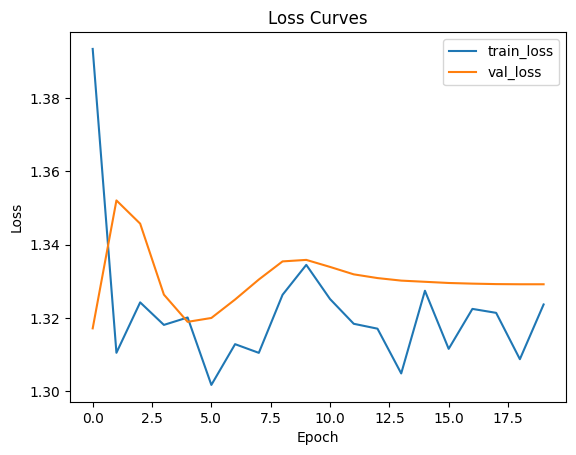

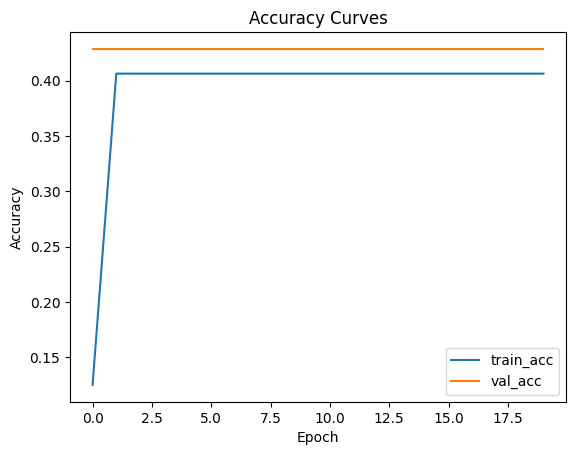

TEST metrics (size=7): loss=1.3148 | acc=0.429
Classification report on test set:
              precision    recall  f1-score   support

           0       0.00      0.00      0.00         2
           1       0.00      0.00      0.00         2
           2       0.43      1.00      0.60         3

    accuracy                           0.43         7
   macro avg       0.14      0.33      0.20         7
weighted avg       0.18      0.43      0.26         7



/home/sysadmin/anaconda3/envs/ml/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/sysadmin/anaconda3/envs/ml/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/sysadmin/anaconda3/envs/ml/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} i

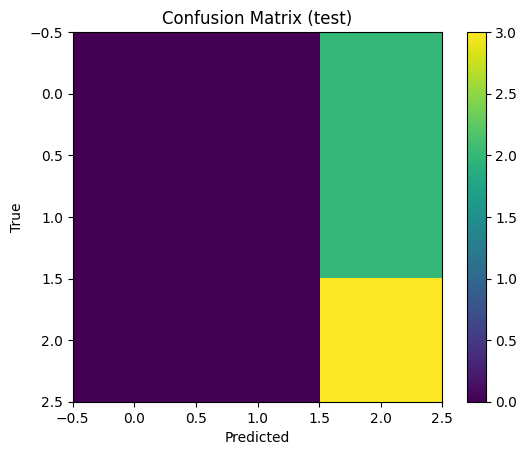

In [34]:
# --- Transformer-only training & evaluation (Option A bins) ---
import torch.nn as nn, torch, numpy as np, matplotlib.pyplot as plt
import pandas as pd
from sklearn.metrics import classification_report, confusion_matrix

class PatchEmbed1D(nn.Module):
    def __init__(self, seq_len, patch_size, embed_dim):
        super().__init__()
        assert seq_len % patch_size == 0
        self.num_patches = seq_len // patch_size
        self.proj = nn.Conv1d(1, embed_dim, kernel_size=patch_size, stride=patch_size)
    def forward(self, x):
        x = x.unsqueeze(1); x = self.proj(x); x = x.transpose(1,2); return x

class SpectralTransformer(nn.Module):
    def __init__(self, seq_len=1024, patch_size=16, embed_dim=128, depth=6, num_heads=4, mlp_ratio=4.0, num_classes=3, dropout=0.1):
        super().__init__()
        self.patch_embed = PatchEmbed1D(seq_len, patch_size, embed_dim)
        num_patches = self.patch_embed.num_patches
        self.cls_token = nn.Parameter(torch.zeros(1,1,embed_dim))
        self.pos_embed = nn.Parameter(torch.randn(1, num_patches+1, embed_dim)*0.02)
        self.pos_drop = nn.Dropout(dropout)
        enc = nn.TransformerEncoderLayer(d_model=embed_dim, nhead=num_heads, dim_feedforward=int(embed_dim*mlp_ratio),
                                         dropout=dropout, batch_first=True, activation="gelu")
        self.encoder = nn.TransformerEncoder(enc, num_layers=depth)
        self.norm = nn.LayerNorm(embed_dim)
        self.head = nn.Linear(embed_dim, num_classes)
        nn.init.trunc_normal_(self.cls_token, std=0.02)
        nn.init.trunc_normal_(self.pos_embed, std=0.02)
        nn.init.trunc_normal_(self.head.weight, std=0.02)
        nn.init.constant_(self.head.bias, 0)
    def forward(self, x):
        x = self.patch_embed(x); B,N,E = x.shape
        cls = self.cls_token.expand(B,-1,-1)
        x = torch.cat([cls,x], dim=1); x = x + self.pos_embed[:, :N+1]; x = self.pos_drop(x)
        x = self.encoder(x); x = self.norm(x[:,0]); return self.head(x)

NUM_CLASSES = pd.read_csv(DATA_CSV)[LABEL_COLUMN].nunique()
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = SpectralTransformer(seq_len=1024, num_classes=NUM_CLASSES).to(device)

def train_one_epoch(model, loader, criterion, optimizer):
    model.train(); rl, rc, n = 0.0, 0, 0
    for xb, yb in loader:
        xb, yb = xb.to(device), yb.to(device)
        optimizer.zero_grad(set_to_none=True)
        logits = model(xb); loss = criterion(logits, yb); loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
        optimizer.step()
        with torch.no_grad():
            preds = logits.argmax(dim=1); rl += loss.item()*xb.size(0); rc += (preds==yb).sum().item(); n += xb.size(0)
    return {"loss": rl/max(n,1), "acc": rc/max(n,1)}

@torch.no_grad()
def evaluate(model, loader, criterion):
    model.eval(); rl, rc, n = 0.0, 0, 0
    for xb, yb in loader:
        xb, yb = xb.to(device), yb.to(device)
        logits = model(xb); loss = criterion(logits, yb); preds = logits.argmax(dim=1)
        rl += loss.item()*xb.size(0); rc += (preds==yb).sum().item(); n += xb.size(0)
    return {"loss": rl/max(n,1), "acc": rc/max(n,1)}

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.AdamW(model.parameters(), lr=3e-4, weight_decay=0.01)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=20)

EPOCHS = 20
history = {"train_loss": [], "train_acc": [], "val_loss": [], "val_acc": []}
best_val_acc, best_state = -1.0, None

for epoch in range(1, EPOCHS+1):
    tr = train_one_epoch(model, train_loader, criterion, optimizer)
    val = evaluate(model, val_loader, criterion)
    scheduler.step()
    history["train_loss"].append(tr["loss"]); history["train_acc"].append(tr["acc"])
    history["val_loss"].append(val["loss"]);   history["val_acc"].append(val["acc"])
    print(f"Epoch {epoch:02d} | train: loss={tr['loss']:.4f}, acc={tr['acc']:.3f} | val: loss={val['loss']:.4f}, acc={val['acc']:.3f}")
    if val["acc"] > best_val_acc:
        best_val_acc = val["acc"]; best_state = {k: v.cpu() for k, v in model.state_dict().items()}

if best_state is not None:
    model.load_state_dict(best_state)
    torch.save(model.state_dict(), "best_model.pt")
    print("Saved best model to best_model.pt with val_acc=", best_val_acc)

# Curves
plt.figure(); plt.plot(history["train_loss"], label="train_loss"); plt.plot(history["val_loss"], label="val_loss")
plt.xlabel("Epoch"); plt.ylabel("Loss"); plt.legend(); plt.title("Loss Curves"); plt.show()
plt.figure(); plt.plot(history["train_acc"], label="train_acc"); plt.plot(history["val_acc"], label="val_acc")
plt.xlabel("Epoch"); plt.ylabel("Accuracy"); plt.legend(); plt.title("Accuracy Curves"); plt.show()

# --- Safe test evaluation ---
@torch.no_grad()
def predict_all(model, loader):
    model.eval(); preds, targets = [], []
    if loader is None: return np.array([]), np.array([])
    for xb, yb in loader:
        xb = xb.to(device); logits = model(xb)
        preds.append(torch.argmax(logits, dim=1).cpu().numpy()); targets.append(yb.numpy())
    if len(preds) == 0: return np.array([]), np.array([])
    return np.concatenate(preds), np.concatenate(targets)

def safe_evaluate(model, loader, criterion, name="loader"):
    if loader is None: return {"loss": float("nan"), "acc": float("nan"), "size": 0, "name": name}
    try: size = len(loader.dataset)
    except Exception: size = None
    if size is not None and size == 0: return {"loss": float("nan"), "acc": float("nan"), "size": 0, "name": name}
    metrics = evaluate(model, loader, criterion); metrics.update({"size": size, "name": name}); return metrics

eval_loader, eval_name = (test_loader, "test") if (test_loader is not None) else (val_loader, "val")
metrics = safe_evaluate(model, eval_loader, criterion, name=eval_name)
print(f"{metrics['name'].upper()} metrics (size={metrics['size']}): loss={metrics['loss']:.4f} | acc={metrics['acc']:.3f}")

y_pred, y_true = predict_all(model, eval_loader)
if y_true.size > 0:
    print(f"Classification report on {eval_name} set:")
    print(classification_report(y_true, y_pred))
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(); plt.imshow(cm, interpolation="nearest"); plt.title(f"Confusion Matrix ({eval_name})")
    plt.xlabel("Predicted"); plt.ylabel("True"); plt.colorbar(); plt.show()
else:
    print("No samples available for final evaluation — skipped report & confusion matrix.")



# Data augmentation (1D spectra)

These augmentations are **physically reasonable** and help when data is small/imbalanced.

* **Gaussian noise**: simulates photon noise (`N(0, σ)`).
* **Continuum scaling / tilt**: multiply by `(a + b*λ̂)`, keeps line ratios but changes slope.
* **Small wavelength jitter**: slight global stretch/compress (simulates redshift/wcal errors).
* **Local dropout masks**: zero out tiny wavelength windows (sky residuals, bad pixels).
* **Random smooth baseline**: add/remove gentle continuum ripples.

Add this transform pipeline to your dataset:

```python
import numpy as np

class SpectralAugment:
    def __init__(self,
                 noise_std=0.01,
                 scale_range=(0.95, 1.05),
                 tilt_range=(-0.03, 0.03),
                 jitter_range=(-0.01, 0.01),     # ±1% stretch
                 drop_prob=0.2,
                 drop_max_width=0.02,            # up to 2% of spectrum
                 p_noise=0.8, p_scale_tilt=0.7, p_jitter=0.3, p_dropout=0.3):
        self.noise_std = noise_std
        self.scale_range = scale_range
        self.tilt_range = tilt_range
        self.jitter_range = jitter_range
        self.drop_prob = drop_prob
        self.drop_max_width = drop_max_width
        self.p_noise = p_noise
        self.p_scale_tilt = p_scale_tilt
        self.p_jitter = p_jitter
        self.p_dropout = p_dropout

    def __call__(self, x):
        # x: numpy 1D array length L in [resampled space]
        L = len(x)
        xi = np.linspace(0, 1, L)

        if np.random.rand() < self.p_scale_tilt:
            a = np.random.uniform(*self.scale_range)
            b = np.random.uniform(*self.tilt_range)
            x = x * (a + b*(xi - 0.5))

        if np.random.rand() < self.p_noise:
            x = x + np.random.normal(0, self.noise_std, size=L).astype(x.dtype)

        if np.random.rand() < self.p_jitter:
            j = np.random.uniform(*self.jitter_range)   # -0.01..0.01
            src = np.linspace(0, 1, L)
            dst = np.clip(src * (1 + j), 0, 1)
            x = np.interp(src, dst, x).astype(x.dtype)

        if np.random.rand() < self.p_dropout:
            width = int(self.drop_max_width * L * np.random.rand()) + 1
            start = np.random.randint(0, max(1, L - width))
            x[start:start+width] = 0.0

        return x
```

# Use in your Dataset:
# train_ds = SpectraFilesDataset(train_df, FILE_COLUMN, LABEL_COLUMN, target_len=1024, ...)
# then inside __getitem__, after resampling:
# if self.augment is not None and self.train: x = self.augment(x)